In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse, optimize, stats
from scipy.special import beta as BF
from matplotlib import colors, cm
from scipy.spatial import KDTree
from scipy.optimize import fsolve
from scipy.stats import nbinom

Load 3 Real Data Samples From Paper

In [9]:
balbc1 = pd.read_pickle('./spleen_data/for_paper/balbc1_data.pkl')
balbc1 = balbc1[['X1_adjusted', 'Y1_adjusted', 'rev_cell_type', 'color']]
balbc1.columns = [ 'X', 'Y', 'Cluster_remap', 'cell_type_color']
balbc1.head()

,X,Y,Cluster_remap,cell_type_color
0,15,221,15,#0087ff
3,12,444,2,#00e9ff
7,16,367,5,#00ff50
12,7,625,26,#ffff00
15,12,464,5,#00ff50


In [10]:
balbc2 = pd.read_pickle('./spleen_data/for_paper/balbc2_minimal_df.pkl')
balbc2 = balbc2[['X1_adjusted', 'Y1_adjusted', 'rev_cell_type']]
balbc2.columns = [ 'X', 'Y', 'Cluster_remap']
balbc2.head()

,X,Y,Cluster_remap
29657,5910,794,26
29658,6472,62,19
29659,5439,407,15
29661,6536,902,19
29662,5417,810,8


In [11]:
balbc3 = pd.read_pickle('./spleen_data/for_paper/balbc3_minimal_df.pkl')
balbc3 = balbc3[['X1_adjusted', 'Y1_adjusted', 'rev_cell_type']]
balbc3.columns = [ 'X', 'Y', 'Cluster_remap']
balbc3.head()

,X,Y,Cluster_remap
0,15,221,15
3,12,444,2
7,16,367,5
12,7,625,26
15,12,464,5


In [70]:
def build_assignment_matrix(attribute_dict, n_cell_types):
    data = list(attribute_dict.items())
    data = np.array(data)  # Assignment matrix

    B = np.zeros((data.shape[0], n_cell_types))  # Empty matrix

    for i in range(0, data.shape[0]):
        t = int(data[i, 1])
        B[i, t] = 1

    return B

def calculate_FOV_size(sampling_frac, min_x, max_x, min_y, max_y):
    area = (max_x - min_x) * (max_y - min_y)
    sampling_area = sampling_frac * area
    FOV_dim = np.round(np.sqrt(sampling_area))
    return FOV_dim

def random_FOV(FOV_dim, df, min_x, max_x, min_y, max_y):
    x_start = np.random.randint(min_x, max_x - FOV_dim)
    y_start = np.random.randint(min_y, max_y - FOV_dim)
    
    x_filtered = df[(df['X'] > x_start) & (df['X'] < x_start + FOV_dim)]
    random_FOV = x_filtered[(x_filtered['Y'] > y_start) & (x_filtered['Y'] < y_start + FOV_dim)]
    
    return random_FOV

def calculate_p_in_fov(fov, n_cell_types):
    types_in_fov = fov['Cluster_remap'].tolist()
    #print(types_in_fov)
    attribute_dict = dict(zip(fov.index, types_in_fov))
    B = build_assignment_matrix(attribute_dict, n_cell_types)
    return np.divide(np.sum(B, axis=0), B.shape[0])

def estimate_beta_from_FOV(df, fov_dim, type_of_interest, n_fov, x_min, x_max, y_min, y_max, n_cell_types):
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) > 10:
            # because we don't define the boundary of the TISSUE just the boundary of the image
            # you could draw an fov out of tissue bounds but in the enclosing rectangle
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        else:
            continue
    print(ns)
    sample_proportions = np.vstack(p_list)
    props_of_interest = sample_proportions[:, type_of_interest]
    
    sample_mean = np.mean(props_of_interest)
    sample_var = np.var(props_of_interest)
    
    #print()
    alpha_hat = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    beta_hat = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    
    #print(sample_mean, sample_var)
    #print(alpha_hat, beta_hat)
    return alpha_hat, beta_hat, props_of_interest, ns

def estimate_beta_from_FOV(df, fov_dim, type_of_interest, n_fov, x_min, x_max, y_min, y_max, n_cell_types):
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) > 10:
            # because we don't define the boundary of the TISSUE just the boundary of the image
            # you could draw an fov out of tissue bounds but in the enclosing rectangle
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        else:
            continue
    print(ns)
    sample_proportions = np.vstack(p_list)
    props_of_interest = sample_proportions[:, type_of_interest]
    
    sample_mean = np.mean(props_of_interest)
    sample_var = np.var(props_of_interest)
    
    #print()
    alpha_hat = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    beta_hat = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)

    return alpha_hat, beta_hat, props_of_interest, ns

def random_FOV_multisample(FOV_prop, df_list):
    '''
    use to draw FOVs from a dataset of multiple samples
    '''

    #choose df
    k = np.random.randint(0, len(df_list))
    df = df_list[k]

    #get bounds
    min_x = min(df['X'])
    max_x = max(df['X'])
    min_y = min(df['Y'])
    max_y = max(df['Y'])

    #calculate FOV size

    FOV_dim = calculate_FOV_size(FOV_prop, min_x, max_x, min_y, max_y)
    x_start = np.random.randint(min_x, max_x - FOV_dim)
    y_start = np.random.randint(min_y, max_y - FOV_dim)
    
    #sample
    x_filtered = df[(df['X'] > x_start) & (df['X'] < x_start + FOV_dim)]
    random_FOV = x_filtered[(x_filtered['Y'] > y_start) & (x_filtered['Y'] < y_start + FOV_dim)]
    
    return random_FOV
def estimate_beta_from_FOV_multisample(df_list, fov_dim, type_of_interest, n_fov, n_cell_types):
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV_multisample(fov_dim, df_list)
        if len(fov) > 5:
            # because we don't define the boundary of the TISSUE just the boundary of the image
            # you could draw an fov out of tissue bounds but in the enclosing rectangle so account for it by ensuring there are cells in the FOV
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        else:
            continue
    print(ns)
    sample_proportions = np.vstack(p_list)
    props_of_interest = sample_proportions[:, type_of_interest]
    
    sample_mean = np.mean(props_of_interest)
    sample_var = np.var(props_of_interest)
    
    #print()
    alpha_hat = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    beta_hat = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)

    return alpha_hat, beta_hat, props_of_interest, ns

def estimate_beta_from_FOV_ds(df, fov_dim, type_of_interest, n_fov, x_min, x_max, y_min, y_max, 
                           n_cell_types, target_size):
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) == target_size:
            # because we don't define the boundary of the TISSUE just the boundary of the image
            # you could draw an fov out of tissue bounds but in the enclosing rectangle
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        elif len(fov) > target_size:
            #n_to_remove = len(fov) - target_size
            fov = fov.sample(n=target_size, replace=False)
            p_list.append(calculate_p_in_fov(fov, n_cell_types))
            ns.append(len(fov))
            i += 1
        else:
            continue
    #print(ns)
    sample_proportions = np.vstack(p_list)
    props_of_interest = sample_proportions[:, type_of_interest]
    
    sample_mean = np.mean(props_of_interest)
    sample_var = np.var(props_of_interest)
    
    #print()
    alpha_hat = sample_mean * (((sample_mean*(1-sample_mean))/sample_var) - 1)
    beta_hat = (1 - sample_mean) * (((sample_mean*(1-sample_mean))/sample_var) - 1)

    return alpha_hat, beta_hat, props_of_interest

def p_fov_with_rarest(a, b, m, N):
    return 1 - np.power((BF(a, b + m)/BF(a, b)), N)

def fov_cell_counts(df, fov_dim, toi, n_fov, x_min, x_max, y_min, y_max, n_cell_types, ret_n = False):
    
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV(fov_dim, df, x_min, x_max, y_min, y_max)
        if len(fov) > 10:
            types_in_fov = fov['Cluster_remap'].astype(int).tolist()
            #print(types_in_fov)
            attribute_dict = dict(zip(fov.index, types_in_fov))
            B = build_assignment_matrix(attribute_dict, n_cell_types)
            p_list.append(np.sum(B, axis=0))
            ns.append(len(fov))
            i += 1
        else:
            continue
        
    sample_counts = np.vstack(p_list)
    
    if ret_n == True:
        return sample_counts[:, toi].astype(int), np.sum(sample_counts, axis=1).astype(int)
    else:
        return sample_counts[:, toi].astype(int)

def fov_cell_counts_multisample(df_list, fov_dim, toi, n_fov, n_cell_types, ret_n = False):
    
    p_list = []
    i = 0
    ns = []
    while i < n_fov:
        fov = random_FOV_multisample(fov_dim, df_list)
        if len(fov) > 5:
            types_in_fov = fov['Cluster_remap'].astype(int).tolist()
            #print(types_in_fov)
            attribute_dict = dict(zip(fov.index, types_in_fov))
            B = build_assignment_matrix(attribute_dict, n_cell_types)
            p_list.append(np.sum(B, axis=0))
            ns.append(len(fov))
            i += 1
        else:
            continue
        
    sample_counts = np.vstack(p_list)
    
    if ret_n == True:
        return sample_counts[:, toi].astype(int), np.sum(sample_counts, axis=1).astype(int)
    else:
        return sample_counts[:, toi].astype(int)
    
def convert_params(m, k):
    """ 
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    Parameters
    ----------
    m : float 
       Mean
    k : float
       Overdispersion parameter. 
    """
    k = 1/k
    var = m + k * m ** 2
    p = (var - m) / var
    r = m ** 2 / (var - m)
    return r, 1-p

def do_model_trials_multisample(df_list, fov_prop, toi, n_cell_types, n_fov, n_trials, samples_to_include):

    trial_counter = 0
    
    def f2(k, p0, m):
            return np.power((m/k + 1), -k) - p0
        
    ns = np.arange(0,20)
    while trial_counter < n_trials:
        #randomize dataset list
        np.random.shuffle(df_list)
        n_toi_observed = fov_cell_counts_multisample(df_list[:samples_to_include], fov_prop, toi, n_fov, n_cell_types)
        values, counts = np.unique(n_toi_observed, return_counts=True)
        v = np.arange(0, max(values) + 1)
        val_count = dict(zip(values, counts))
        c = np.array([val_count[i] if i in values else 0 for i in v])
        
        #Parameter estimation with ZTM method
        n0 = c[0]
        N = np.sum(c)
        p0 = n0/N
        m = np.mean(n_toi_observed)
        k = fsolve(f2, x0=0.2, args=(p0, m))
        r, p = convert_params(m, k[0])
        
        x = np.arange(0, 60)
        if trial_counter == 0:
            res = nbinom.pmf(x, r, p)
            fov = p_discovery_in_n_fov(p0, ns)
        else:
            res = np.vstack((res, nbinom.pmf(x, r, p)))
            fov = np.vstack((fov, p_discovery_in_n_fov(p0, ns)))
        trial_counter += 1 
    
    return res, fov

def p_discovery_in_n_fov(p0, n):
        return 1 - np.power(p0, n)

In [71]:
datasets = [balbc1, balbc2, balbc3]
#fov_size = 0.05
toi = 2
n_fov = 30
n_trials = 50
n_cell_types = 27
#samples_to_include = 1

In [72]:
#1 Sample
samples_to_include = 1
print('1 sample')
res_05r_1, fov_05r_1 = do_model_trials_multisample(df_list=datasets,fov_prop=0.005, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=1)
res_5r_1, fov_5r_1 = do_model_trials_multisample(df_list=datasets,fov_prop=0.05, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=1)
res_1r_1, fov_1r_1 = do_model_trials_multisample(df_list=datasets,fov_prop=0.01, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=1)

#2 samples
print('2 samples')
samples_to_include = 2
res_05r_2, fov_05r_2 = do_model_trials_multisample(df_list=datasets,fov_prop=0.005, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=2)
res_5r_2, fov_5r_2 = do_model_trials_multisample(df_list=datasets,fov_prop=0.05, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=2)
res_1r_2, fov_1r_2 = do_model_trials_multisample(df_list=datasets,fov_prop=0.01, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=2)

#3 samples
print('3 samples')
samples_to_include = 3
res_05r_3, fov_05r_3 = do_model_trials_multisample(df_list=datasets,fov_prop=0.005, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=3)
res_5r_3, fov_5r_3 = do_model_trials_multisample(df_list=datasets,fov_prop=0.05, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=3)
res_1r_3, fov_1r_3 = do_model_trials_multisample(df_list=datasets,fov_prop=0.01, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=3)

1 sample


/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(m

2 samples


/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(m

3 samples


/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(m

In [73]:
thresh = 0.8
ns = [1, 2, 3]

arrs_1 = [fov_05r_1, fov_05r_2, fov_05r_3]
means_1 = []
ci_1 = []
for a in arrs_1: 
    res = np.argmax(a > thresh, axis = 1)
    mean = np.mean(res)
    std = np.std(res)
    ci = stats.norm.ppf(0.95) * (std/np.sqrt(res.shape[0]))
    means_1.append(mean)
    ci_1.append(ci)

arrs_2 = [fov_1r_1, fov_1r_2, fov_1r_3]
means_2 = []
ci_2 = []
for a in arrs_2: 
    res = np.argmax(a > thresh, axis = 1)
    mean = np.mean(res)
    std = np.std(res)
    ci = stats.norm.ppf(0.95) * (std/np.sqrt(res.shape[0]))
    means_2.append(mean)
    ci_2.append(ci)

arrs_3 = [fov_5r_1, fov_5r_2, fov_5r_3]
means_3 = []
ci_3 = []
for a in arrs_3: 
    res = np.argmax(a > thresh, axis = 1)
    mean = np.mean(res)
    std = np.std(res)
    ci = stats.norm.ppf(0.95) * (std/np.sqrt(res.shape[0]))
    means_3.append(mean)
    ci_3.append(ci)

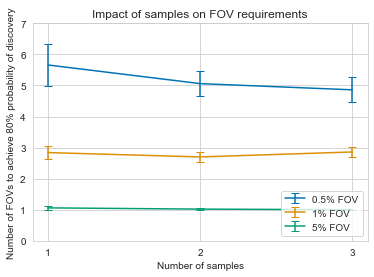

In [74]:
sns.set_style('whitegrid')
plt.errorbar(ns, means_1, yerr=ci_1, label='0.5% FOV', color = sns.color_palette('colorblind')[0%4], capsize=4)
plt.errorbar(ns, means_2, yerr=ci_2, label='1% FOV', color = sns.color_palette('colorblind')[1%4], capsize=4)
plt.errorbar(ns, means_3, yerr=ci_3, label='5% FOV', color = sns.color_palette('colorblind')[2%4], capsize=4)
_ = plt.xticks(ticks=ns)
plt.ylim(0,7)
plt.xlabel("Number of samples")
plt.ylabel("Number of FOVs to achieve 80% probability of discovery")
plt.title("Impact of samples on FOV requirements")
plt.legend(loc=4)
plt.show()

Simulated Visium Data

In [75]:
balbc1_vis = pd.read_csv('./balbc1_binned.csv', header=0, index_col=0)
balbc2_vis = pd.read_csv('./balbc2_binned.csv', header=0, index_col=0)
balbc3_vis = pd.read_csv('./balbc3_binned.csv', header=0, index_col=0)
balbc1_vis.columns = ['X', 'Y', 'Cluster_remap']
balbc2_vis.columns = ['X', 'Y', 'Cluster_remap']
balbc3_vis.columns = ['X', 'Y', 'Cluster_remap']

In [76]:
datasets = [balbc1_vis, balbc1_vis, balbc3_vis]
#fov_size = 0.05
toi = 1
n_fov = 30
n_trials = 50
n_cell_types = 27
#samples_to_include = 1

In [77]:
#1 Sample
samples_to_include = 1
print('1 sample')
res_05r_1v, fov_05r_1v = do_model_trials_multisample(df_list=datasets,fov_prop=0.005, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=1)
res_5r_1v, fov_5r_1v = do_model_trials_multisample(df_list=datasets,fov_prop=0.05, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=1)
res_1r_1v, fov_1r_1v = do_model_trials_multisample(df_list=datasets,fov_prop=0.01, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=1)

#2 samples
print('2 samples')
samples_to_include = 2
res_05r_2v, fov_05r_2v = do_model_trials_multisample(df_list=datasets,fov_prop=0.005, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=2)
res_5r_2v, fov_5r_2v = do_model_trials_multisample(df_list=datasets,fov_prop=0.05, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=2)
res_1r_2v, fov_1r_2v = do_model_trials_multisample(df_list=datasets,fov_prop=0.01, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=2)

#3 samples
print('3 samples')
samples_to_include = 3
res_05r_3v, fov_05r_3v = do_model_trials_multisample(df_list=datasets,fov_prop=0.005, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=3)
res_5r_3v, fov_5r_3v = do_model_trials_multisample(df_list=datasets,fov_prop=0.05, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=3)
res_1r_3v, fov_1r_3v = do_model_trials_multisample(df_list=datasets,fov_prop=0.01, toi=toi, n_cell_types=n_cell_types, n_fov=n_fov, n_trials = n_trials, samples_to_include=3)

1 sample


/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(m

2 samples


/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(m

3 samples


/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(m

In [78]:
thresh = 0.8
ns = [1, 2, 3]

arrs_1v = [fov_05r_1v, fov_05r_2v, fov_05r_3v]
means_1v = []
ci_1v = []
for a in arrs_1v: 
    res = np.argmax(a > thresh, axis = 1)
    mean = np.mean(res)
    std = np.std(res)
    ci = stats.norm.ppf(0.95) * (std/np.sqrt(res.shape[0]))
    means_1v.append(mean)
    ci_1v.append(ci)

arrs_2v = [fov_1r_1v, fov_1r_2v, fov_1r_3v]
means_2v = []
ci_2v = []
for a in arrs_2v: 
    res = np.argmax(a > thresh, axis = 1)
    mean = np.mean(res)
    std = np.std(res)
    ci = stats.norm.ppf(0.95) * (std/np.sqrt(res.shape[0]))
    means_2v.append(mean)
    ci_2v.append(ci)

arrs_3v = [fov_5r_1v, fov_5r_2v, fov_5r_3v]
means_3v = []
ci_3v = []
for a in arrs_3v: 
    res = np.argmax(a > thresh, axis = 1)
    mean = np.mean(res)
    std = np.std(res)
    ci = stats.norm.ppf(0.95) * (std/np.sqrt(res.shape[0]))
    means_3v.append(mean)
    ci_3v.append(ci)

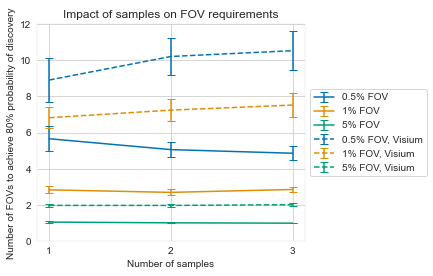

In [83]:
import matplotlib
sns.set_style('whitegrid')

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})


fig = plt.figure()
ax = plt.subplot(111)

ax.errorbar(ns, means_1, yerr=ci_1, label='0.5% FOV', color = sns.color_palette('colorblind')[0%4], capsize=4)
ax.errorbar(ns, means_2, yerr=ci_2, label='1% FOV', color = sns.color_palette('colorblind')[1%4], capsize=4)
ax.errorbar(ns, means_3, yerr=ci_3, label='5% FOV', color = sns.color_palette('colorblind')[2%4], capsize=4)

ax.errorbar(ns, means_1v, yerr=ci_1v, label='0.5% FOV, Visium', color = sns.color_palette('colorblind')[0%4], capsize=4, ls='--')
ax.errorbar(ns, means_2v, yerr=ci_2v, label='1% FOV, Visium', color = sns.color_palette('colorblind')[1%4], capsize=4,ls='--')
ax.errorbar(ns, means_3v, yerr=ci_3v, label='5% FOV, Visium', color = sns.color_palette('colorblind')[2%4], capsize=4, ls='--')


_ = plt.xticks(ticks=ns)
ax.set_ylim(0,12)
ax.set_xlabel("Number of samples")
ax.set_ylabel("Number of FOVs to achieve 80% probability of discovery")
plt.title("Impact of samples on FOV requirements")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('./samples_vs_FOV_visium_CODEX.pdf')
plt.show()